In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
%matplotlib inline
sns.set()

-----

# EDA, Hypothesis Test & Prediction for babynames

General Tasks:
* Find "the best" name for our baby (ETA July 2017)
* Use what we learnt from stats class to apply to this dataset

### Task 0: Load Data

Data source is from:
* [Google Kaggle](https://www.kaggle.com/kaggle/us-baby-names): in csv, but not up to date (until 2014)
* [data.gov](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data): one txt file per year, up to date (until 2015)

Run a python code to transform *.txt into NationalNames.csv

In [73]:
raw_national = pd.read_csv("../data/NationalNames.csv")
raw_national.shape

(1825737, 5)

In [74]:
raw_national.head()

,Id,Name,Year,Gender,Count
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746


In [81]:
# more than 5M rows, let's choose a sample
# raw_nat_sample = raw_national.sample(n=100000)

raw_nat_sample = raw_national.copy()
raw_nat_sample.shape

(1825737, 5)

### Task 0: Pythonize Column Names

In [82]:
# take a look
raw_nat_sample.columns = map(lambda x : x.lower().replace(' ','_').replace('count','frequency'),raw_nat_sample.columns)
raw_nat_sample.head(10)

,id,name,year,gender,frequency
0,1,Mary,1880,F,7065
1,2,Anna,1880,F,2604
2,3,Emma,1880,F,2003
3,4,Elizabeth,1880,F,1939
4,5,Minnie,1880,F,1746
5,6,Margaret,1880,F,1578
6,7,Ida,1880,F,1472
7,8,Alice,1880,F,1414
8,9,Bertha,1880,F,1320
9,10,Sarah,1880,F,1288


### Task 1: find out classical names

Classical name is names with longest historical data. Because if a name appears in each every year, it means it's popular.

In [84]:
name_year_count = raw_nat_sample.copy()
name_year_count['history'] = name_year_count.groupby(['name','gender'])['year']\
                                            .transform('count')
name_year_count.head(10)

,id,name,year,gender,frequency,history
0,1,Mary,1880,F,7065,135
1,2,Anna,1880,F,2604,135
2,3,Emma,1880,F,2003,135
3,4,Elizabeth,1880,F,1939,135
4,5,Minnie,1880,F,1746,135
5,6,Margaret,1880,F,1578,135
6,7,Ida,1880,F,1472,135
7,8,Alice,1880,F,1414,135
8,9,Bertha,1880,F,1320,135
9,10,Sarah,1880,F,1288,135


In [85]:
# find names with most long history data
def get_classical_name_billboard(since=1880):
    '''
    since: data since which year
    
    return: DataFrame with:
        - Index = ['name','gender']
        - Columns = ['history',frequency'] (sorted)
    '''
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':sum,'history':min}) \
    .sort_values(by=['history','frequency'], ascending=False)

# print top 5 of classical name billboard
print(get_classical_name_billboard().head())

def find_classical_rank(name,gender,since=1910):
    '''
    name, e.g.'John'
    gender, e.g. 'M' or 'F'
    
    return: rank integer in classical name billboard
    '''
    #print(names_with_long_history_sorted.head())
    billboard = get_classical_name_billboard(since).reset_index()
    return billboard[(billboard.name==name) & (billboard.gender==gender)].index[0]+1


find_classical_rank('Rachel','F',since=1910)

                frequency  history
name    gender                    
James   M         5106285      135
John    M         5085371      135
Robert  M         4796992      135
Michael M         4309607      135
Mary    F         4115456      135


79

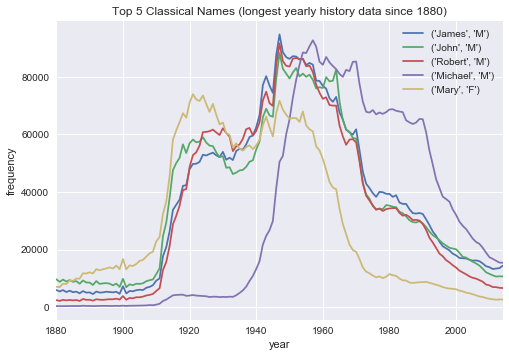

In [87]:
# print the most classical name (name with longest yearly history data)

N = 5
since=1880

classical_billboard = get_classical_name_billboard(since=since)
classical_billboard.head()

# build a Series of frequency, with index ('name','gender','year')
year_frequency = name_year_count.groupby(['name','gender','year']).frequency.sum()

for i in range(N):
    # we need this evil for loop, otherwise dropna() is dropping the whole column
    year_frequency[classical_billboard.index[i]].plot(kind='line');
    
plt.legend(classical_billboard.index[:N])
plt.title(f"Top {N} Classical Names (longest yearly history data since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Taks 2: find out frequent names

Frequent names is purely depends on frequency of past occurance, since a particular year, regardless of "how many years of historical data".

In [11]:
def get_frequent_name_billboard(since=1880):
    '''
    since: begining of year
    
    return: DataFrame with:
    - Index = [name, gender]
    - Columns = [avg_yearly_frequency]
    '''
    return name_year_count[name_year_count.year >= since].groupby(['name','gender']) \
    .aggregate({'frequency':'mean'}) \
    .sort_values(by=['frequency'], ascending=False)

get_frequent_name_billboard().head()

,,frequency
name,gender,
James,M,37824.333333
John,M,37669.414815
Robert,M,35533.274074
Michael,M,31923.014815
Mary,F,30484.859259


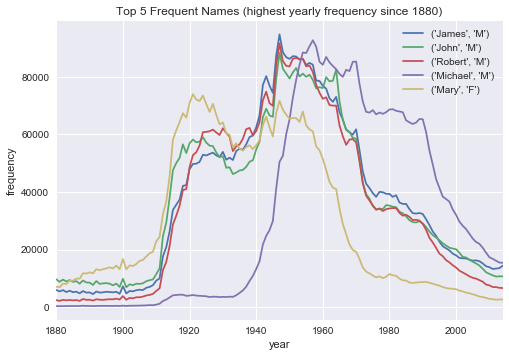

In [92]:
# print the most popular name (name with highest avg yearly frequency across history data)

N = 5
since=1880

frequent_name_billboard = get_frequent_name_billboard(since=since)

# year_frequency is previously loded.
# It is a Series of frequency with index: ('name','gender','year')
for i in range(N):
    year_frequency[frequent_name_billboard.index[i]].dropna().plot(kind='line');

plt.legend(frequent_name_billboard.index[:N])
plt.title(f"Top {N} Frequent Names (highest yearly frequency since {since})");
plt.xlabel("year");
plt.ylabel("frequency");

### Task 3: print out frequency trend by given (name, gender)

Find out what is the yearly frequency trend by given (name, gender)

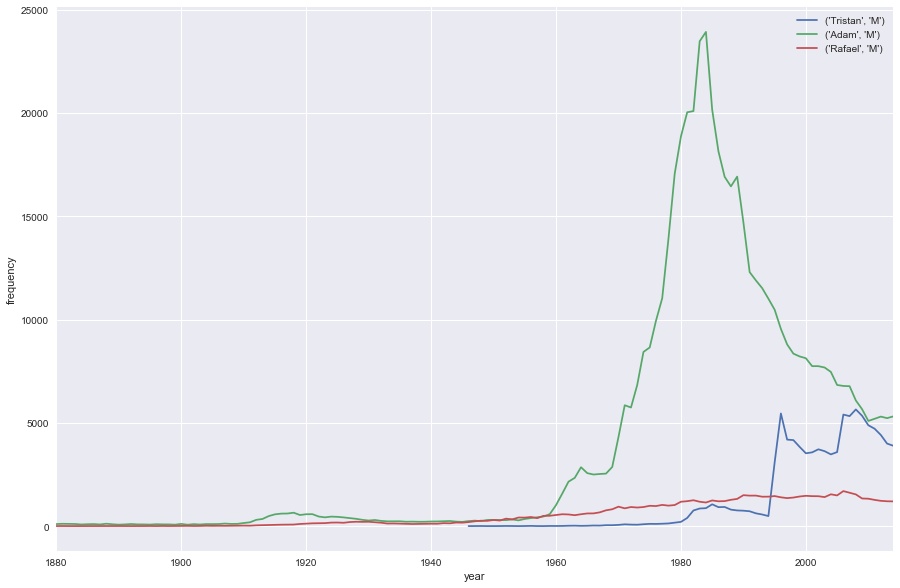

In [101]:
def print_name_frequency_trend(names,since=1880,figsize=(15,10)):
    """ Given a list of names, plot name yearly frequency trend"""
    plt.figure()
    plt.xlabel("year")
    plt.ylabel("frequency")
    # filter Series ('name','gender','year') such that 'year' > since
    year_frequency_filtered = year_frequency.loc[:,:,since:]
    
    # plot only valid names, ignore 
    valid_names = list()
    # given ('name','gender'), plot all possible 'year'
    for name in names:
        if name in year_frequency_filtered.index:
            year_frequency_filtered[name].plot(kind='line',figsize=figsize);
            valid_names.append(name)
    plt.legend(valid_names)

print_name_frequency_trend([('Tristan','M'),('Adam','M'),('Rafael','M')],since=1880)

### Task 4: find popular of names

Add column popularity by following definition:

$ popularity = \frac{frequency of (gender, name ,year)}{frequency of (gender,year)} $

Popularity is the percentage of frequency that a particular name takes among the same (year,gender) pair.

In [14]:
sample = raw_nat_sample.copy()

# prepare frequency_sum per (gender,year) group
pop_total = sample.groupby(['year','gender'])['frequency'].transform(sum)

# populate derived column: popularity
sample['popularity'] = sample['frequency']/pop_total

In [15]:
print(sample.shape)
print(raw_nat_sample.shape)
sample.head()

(1825737, 5)
(1825737, 4)


,name,year,gender,frequency,popularity
id,,,,,
1585933,Aaban,2007,M,5,0.000002
1654167,Aaban,2009,M,6,0.000003
1685637,Aaban,2010,M,9,0.000005
1718295,Aaban,2011,M,11,0.000006
1752147,Aaban,2012,M,11,0.000006


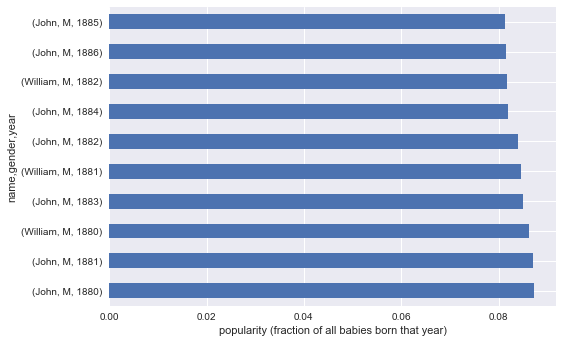

In [102]:
# show top N popular name of the year
plt.ylabel("(name,gender,year) pair")
plt.xlabel("popularity (fraction of all babies born that year)")
N = 10
sample.groupby(['name','gender','year']) \
      .popularity.sum() \
      .sort_values(ascending=False).head(N)\
      .plot(kind='barh');

### Task 5: which name has the largest sudden popularity gain compared to previous year

In [108]:
# inspired by https://www.kaggle.com/dvasyukova/d/kaggle/us-baby-names/the-biggest-impacts-on-name-popularity

def popularity_diff(group,count_first_seen_since=1880):
    '''
    group: group by object
    count_first_seen_since: before this year, the 1st time you see a name is counted 0 pop diff
    '''
    # build year diff series
    yd = group.year.diff().fillna(0)
    # build popularity diff series
    popd = group.popularity.diff()
    # when there's a gap in year, treat the gap as 0
    # which means pop diff is the same as pop itself
    popd.loc[yd>1] = group.popularity.loc[yd>1]
    # reset first row per group to 0 before certain year
    popd.iloc[0] = group.popularity.iloc[0] if group.year.iloc[0] >= count_first_seen_since else 0
    
    return popd

In [104]:
def get_sudden_popular_name_billboard(since=1910):
    return sample[sample.year >=since].sort_values(by=['popdiff'],ascending=False)

In [105]:
def find_sudden_popular_rank(name,gender,since=1910):
    score = get_sudden_popular_name_billboard(since=since).reset_index()
    return score[(score.name==name) & (score.gender == gender)].index[0]+1

In [111]:
since = 2000
sample.head()

,name,year,gender,frequency,popularity,popdiff,length,gender_bin
id,,,,,,,,
1585933,Aaban,2007,M,5,0.000002,2.412539e-06,5,0
1654167,Aaban,2009,M,6,0.000003,3.030464e-06,5,0
1685637,Aaban,2010,M,9,0.000005,1.670186e-06,5,0
1718295,Aaban,2011,M,11,0.000006,1.106361e-06,5,0
1752147,Aaban,2012,M,11,0.000006,1.035864e-08,5,0


In [109]:
# WARNING: it runs for 10min...
sample['popdiff']=sample.groupby(['name','gender']) \
                        .apply(popularity_diff,count_first_seen_since=since)\
                        .reset_index().set_index('id').popularity

In [20]:
find_sudden_popular_rank('Sophia','F',since=since)

190

In [110]:
get_sudden_popular_name_billboard().head(10)

,name,year,gender,frequency,popularity,popdiff,length,gender_bin
id,,,,,,,,
431054,Linda,1947,F,99680,0.056232,0.022686,5,1
321476,Shirley,1935,F,42354,0.040396,0.018521,7,1
922362,Ashley,1983,F,33290,0.019932,0.011159,6,1
711390,Jennifer,1971,F,56785,0.034134,0.007731,8,1
726681,Jennifer,1972,F,63610,0.041815,0.007680,8,1
312297,Shirley,1934,F,22839,0.021875,0.007670,7,1
751898,Jason,1973,M,46689,0.029940,0.006864,5,0
645387,Michelle,1966,F,27153,0.016049,0.006861,8,1
844740,Amanda,1979,F,31927,0.019891,0.006493,6,1


In [22]:
# top N sudden popular names by gender
N = 5
since = 2000
gender = 'M'

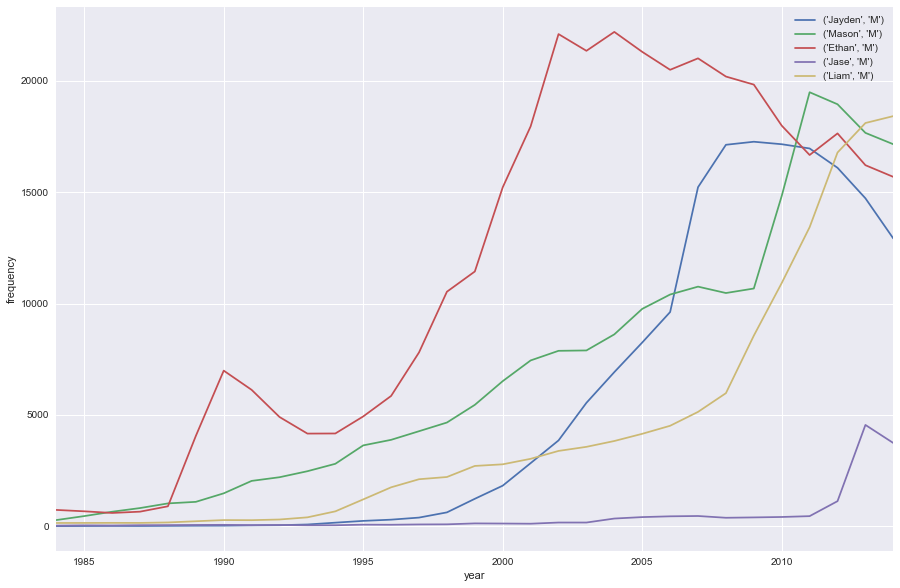

In [23]:
scores = get_sudden_popular_name_billboard(since=since)[['name','gender']]
names = [(name, gender) for name in scores.name[scores.gender == gender].unique()[:N]]
print_name_frequency_trend(names,since=1984)

### Task 6: find good name that starts with 'S', for both boy and girl

#### Frequent Name

In [113]:
N = 5
since = 1880
gender = 'F'

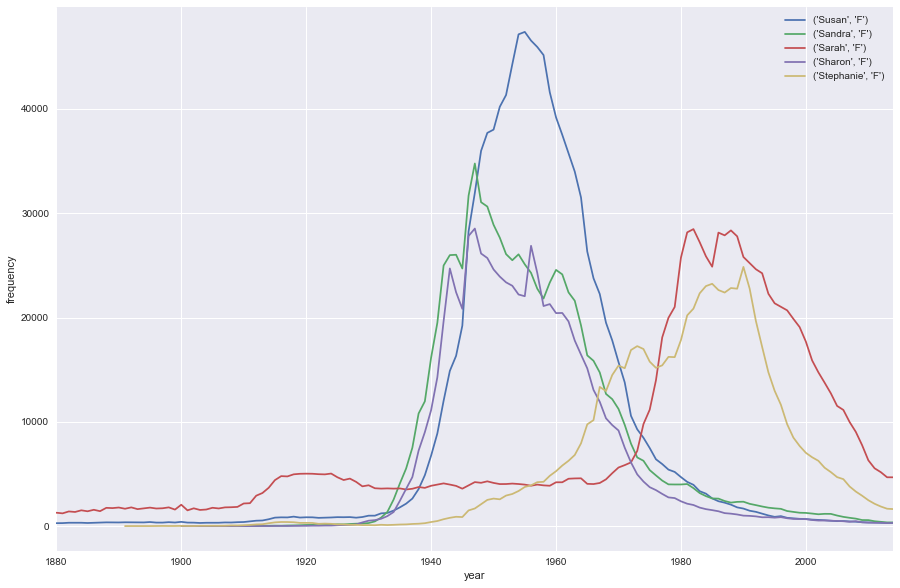

In [114]:
freq_names = get_frequent_name_billboard(since=since).reset_index()
print_name_frequency_trend(freq_names[(freq_names.gender == gender) & (freq_names.name.str.contains('^S'))][:N][['name','gender']].apply(tuple,axis=1),since=since)

#### Popular Name

In [26]:
N = 5
since = 2000
gender = 'M'

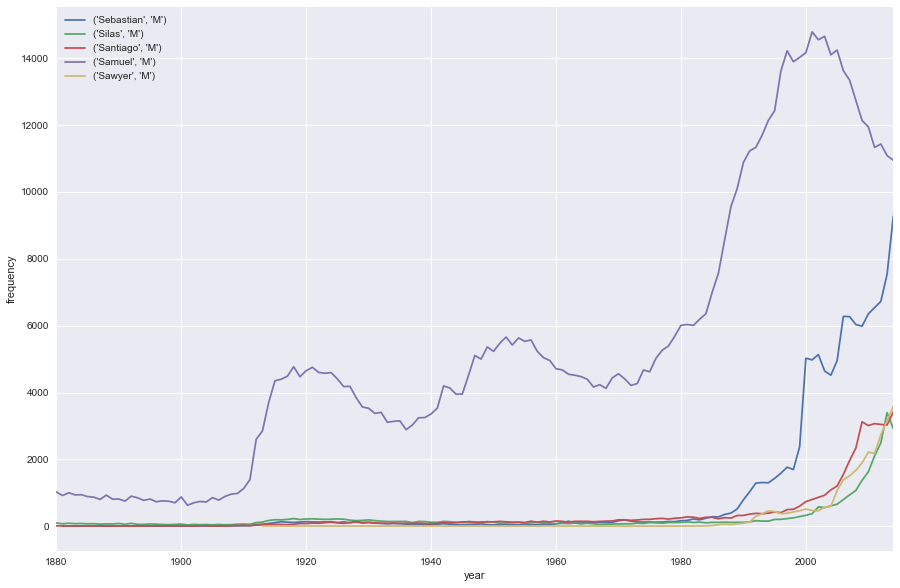

In [27]:
table = get_sudden_popular_name_billboard(since=since)

names = table[(table.name.str.contains('^S')) & (table.gender==gender)].groupby(['gender','name']).first().sort_values(by='popdiff',ascending=False).reset_index()[['name','gender']].apply(tuple,axis=1)[:N]

print_name_frequency_trend(names,since=1880)

### Task 7:  Analyze impact of movies on name

In [28]:
since = 1880

In [29]:
data = get_sudden_popular_name_billboard(since=since)

In [30]:
data = data[data.name == 'Tristan']
data.head()

,name,year,gender,frequency,popularity,popdiff
id,,,,,,
1212575,Tristan,1995,M,3088,0.001623,0.001368
1238737,Tristan,1996,M,5459,0.002883,0.001260
1539082,Tristan,2006,M,5405,0.002633,0.000835
1608489,Tristan,2008,M,5654,0.002776,0.000204
915276,Tristan,1982,M,761,0.000419,0.000197


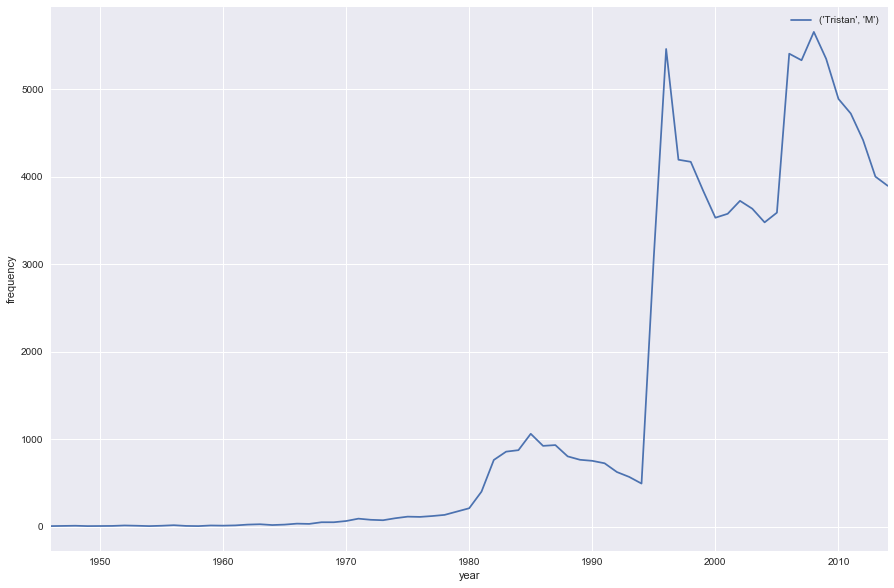

In [31]:
print_name_frequency_trend([('Tristan','M')])

[Lengend of the Fall (1994)](https://en.wikipedia.org/wiki/Legends_of_the_Fall)

### Task 8: Name Frequency Fit Distribution - Power Law

Power Law: $y = ax^b$

Log Power Law: $log(y) = log(a) + blog(x)$

Link Function: $log$

In [32]:
# from scipy import optimize
import statsmodels.formula.api as smf

In [60]:
topN = 100

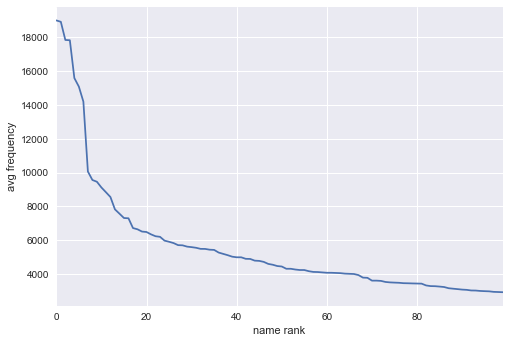

In [61]:
freq = sample.groupby(['name'])['frequency'].mean().sort_values(ascending=False)[:topN]
freq = pd.DataFrame(freq).reset_index()
freq.frequency.plot();
plt.xlabel("name rank")
plt.ylabel("avg frequency");

In [62]:
ydata = freq.frequency.values / freq.frequency.sum()
xdata = freq.index.values + 1 # avoid 0, which gives inf

In [63]:
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

In [64]:
##########
# Fitting the data -- OLS
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#

logx = np.log(xdata)
logy = np.log(ydata)
x = np.vander(logx,N=2)
result = smf.OLS(logy,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     4148.
Date:                Thu, 09 Mar 2017   Prob (F-statistic):           5.15e-82
Time:                        22:13:50   Log-Likelihood:                 125.64
No. Observations:                 100   AIC:                            -247.3
Df Residuals:                      98   BIC:                            -242.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4853      0.008    -64.401      0.000      -0.500      -0.470
const         -2.9644      0.028   -104.825      0.000      -3.021      -2.908
==============================================================================
Omnibus:                       63.454   Durbin-Watson:                   0.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.531
Skew:                          -1.549   Prob(JB):                    5.32e-208
Kurtosis:                      17.815   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
index = result.params[0]
amp = np.exp(result.params[1])
print("index={},amp={}".format(index,amp))

index=-0.4853052400820028,amp=0.051591402419258754


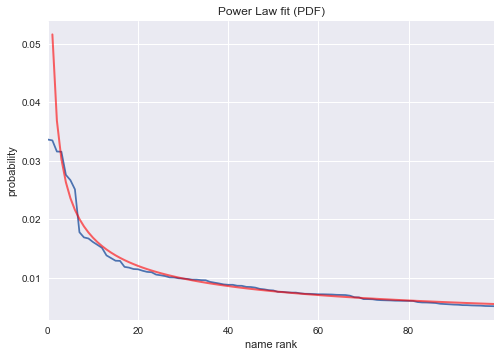

In [66]:
(freq.frequency / freq.frequency.sum()).plot();
x = np.linspace(1,topN,topN)
plt.plot(x, powerlaw(x,amp,index),'r-', lw=2, alpha=0.6, label='powerlaw pdf');
plt.xlabel("name rank")
plt.ylabel("probability")
plt.title("Power Law fit (PDF)");

### Task 8: Hypothesis Testing

#### Teaser

Yesterday I attended a deeplearning4j workshop, and the guy sitting next to me from Salesforce is named Zachary.

$H_0$: I told the truth (because I always do)

$H_1$: I lied.

In [40]:
# define statistics >> power law curve
# compute statistics >> rank of x
freq[freq.name=='Zachary']

,name,frequency
75,Zachary,3489.543624


In [41]:
# compute p-value and compare with significant level α = 0.05
powerlaw(76,amp,index)

0.0022611050240215159

The p-value of meeting a guy named Zachary is less than significant level α = 0.05

Therefore, we reject the null hypothesis, which means I lied.

Fact: the guy sitting next to me from Salesforce was called Mehmet....

What's going wrong?
* It's not CLT (no normal curve). 
* It's point estimate from my power law distribution

-----
#### Miracle gU5

Let's do it again with CLT. Let's see whether gU5 class is a miracle!

$H_0$: it is normal to have a randomly assembled class with same name composition of gU5

$H_a$: it is not normal to have a randomly assembled class with same name compostion of gU5

In [42]:
population = sample.groupby(['name'])['frequency'].mean().sort_values(ascending=False)
population = pd.DataFrame(population).reset_index()
μ = population.frequency.mean()
σ = population.frequency.std()
print("μ = {} σ = {}".format(μ,σ))

μ = 29.317592333584503 σ = 244.0506219624064


In [43]:
gU5 = ['Adam',
       'Anton',
       'Ashleigh',
       'Chase',
       'Derek',
       'Eli',
       'Gavin',
       'Jaichitra',
       'Jed',
       'Jerry',
       'Minheng',
       'Paul',
       'Rafael',
       'Se',
       'Tai',
       'Tristan',
       'Vanessa',
       'Viviane'
      ]

In [44]:
gU5_en = list(set(gU5).intersection(population.name.values))
gU5_en

['Vanessa',
 'Jerry',
 'Tristan',
 'Eli',
 'Ashleigh',
 'Viviane',
 'Jed',
 'Paul',
 'Gavin',
 'Anton',
 'Se',
 'Derek',
 'Chase',
 'Adam',
 'Rafael',
 'Tai']

In [45]:
names_sample = population[population.name.isin(gU5_en)]
s = names_sample.std()[0]
x_ = names_sample.mean()[0]
t_score = (x_ - μ)/(s/np.sqrt(len(gU5_en)))
z_score = (x_ - μ)/σ
print("T Score:",t_score)
print("P Value for T Score is",stats.t(len(gU5_en) - 1).cdf(-t_score))
print("Z Score:",z_score)
print("P Value for Z Score is",stats.norm(0,1).cdf(-z_score))

T Score: 3.21936409557
P Value for T Score is 0.00286599721235
Z Score: 4.77366365309
P Value for Z Score is 9.04522078376e-07


Both p-value for T Score and Z Score is less than significant level α = 0.05

Reject null hypothesis, and __gU5 IS a miracle__!

### Task 9: predict average length of names - Polynomial Regression

In [46]:
sample['length']=sample.name.str.len()

In [47]:
sample.head()

,name,year,gender,frequency,popularity,popdiff,length
id,,,,,,,
1585933,Aaban,2007,M,5,0.000002,2.412539e-06,5
1654167,Aaban,2009,M,6,0.000003,3.030464e-06,5
1685637,Aaban,2010,M,9,0.000005,1.670186e-06,5
1718295,Aaban,2011,M,11,0.000006,1.106361e-06,5
1752147,Aaban,2012,M,11,0.000006,1.035864e-08,5


In [48]:
namelen = sample.groupby(['year'])['length'].mean()
namelen = pd.DataFrame(namelen).reset_index()

In [49]:
namelen.head()

,year,length
0,1880,5.700000
1,1881,5.674419
2,1882,5.724024
3,1883,5.697217
4,1884,5.716152


In [50]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

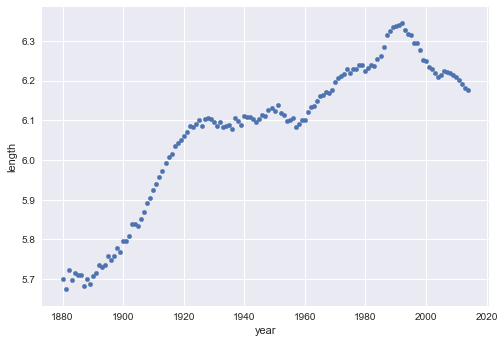

In [51]:
namelen.plot.scatter('year','length');

#### Linear

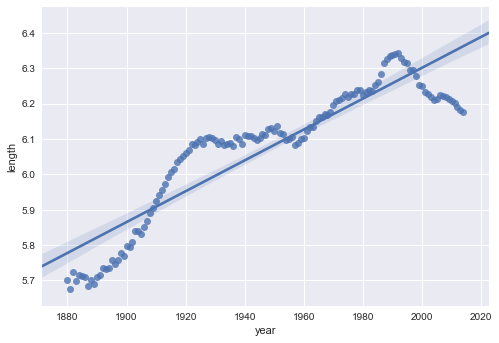

In [52]:
sns.regplot(namelen.year,namelen.length,order=1);

#### Polynomial

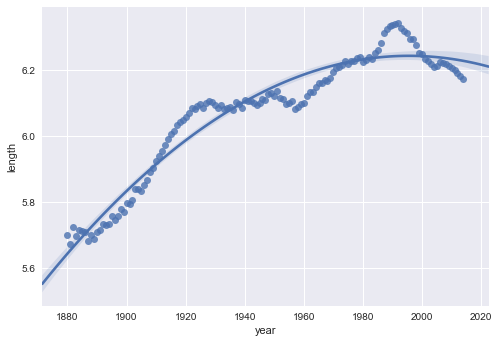

In [53]:
sns.regplot(namelen.year,namelen.length,order=2);

In [54]:
x = np.vander(namelen.year,N = 3)
y = namelen.length.values
result = smf.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1008.
Date:                Thu, 09 Mar 2017   Prob (F-statistic):           1.12e-80
Time:                        21:07:24   Log-Likelihood:                 223.44
No. Observations:                 135   AIC:                            -440.9
Df Residuals:                     132   BIC:                            -432.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4.492e-05   2.96e-06    -15.163      0.000   -5.08e-05   -3.91e-05
x2             0.1793      0.012     15.541      0.000       0.156       0.202
const       -172.6564     11.228    -15.377      0.000    -194.867    -150.446
==============================================================================
Omnibus:                        8.007   Durbin-Watson:                   0.078
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                5.665
Skew:                           0.370   Prob(JB):                       0.0589
Kurtosis:                       2.323   Cond. No.                     1.06e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
# predict
year_to_predict = 2020
result.predict([year_to_predict**2, year_to_predict, 1])

array([ 6.21739011])

### Task 10: predict gender - Logistic Regression

In [117]:
sample['gender_bin'] = sample.gender.apply({'M':0,'F':1}.get)
data = sample[:1000]
result = smf.logit(formula="gender_bin ~ length + year + frequency",data=data).fit();

Optimization terminated successfully.
         Current function value: 0.538837
         Iterations 8


In [118]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             gender_bin   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.1603
Time:                        01:01:11   Log-Likelihood:                -538.84
converged:                       True   LL-Null:                       -641.70
                                        LLR p-value:                 2.450e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5092     17.726      0.424      0.672     -27.232      42.251
length         0.9890      0.081     12.248      0.000       0.831       1.147
year          -0.0065      0.009     -0.733      0.464      -0.024       0.011
frequency      0.0007      0.000      1.475      0.140      -0.000       0.002
==============================================================================
"""

In [119]:
# stripping off year and frequency, coz p-value is larger than significant level 0.05
result = smf.logit(formula="gender_bin ~ length",data=data).fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.541638
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             gender_bin   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 Mar 2017   Pseudo R-squ.:                  0.1559
Time:                        01:01:12   Log-Likelihood:                -541.64
converged:                       True   LL-Null:                       -641.70
                                        LLR p-value:                 1.969e-45
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5308      0.492    -11.235      0.000      -6.496      -4.566
length         1.0064      0.081     12.438      0.000       0.848       1.165
==============================================================================
"""

In [220]:
namelength = 11
to_predict = pd.DataFrame(data=[namelength],columns=['length'])
print("Probability that a name with length {} is female name is {:.3%}".format(
    namelength,
    result.predict(to_predict)[0])
     )

# randomly pick one and check
s = data[data.length == namelength].sample(1)
print("Validation: {},{}".format(s.name.values[0],
                                 s.gender.values[0]))

Probability that a name with length 11 is female name is 99.609%
Validation: Aaliyahrose,F
